In [1]:
pip install missingno

  Obtaining dependency information for missingno from https://files.pythonhosted.org/packages/87/22/cd5cf999af21c2f97486622c551ac3d07361ced8125121e907f588ff5f24/missingno-0.5.2-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as date
import missingno as msno
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, LabelEncoder

In [7]:
def load_titanic():
    data = pd.read_csv('C:/Users/Sameer/Downloads/titanic.csv')
    return data

In [8]:
df1 = load_titanic()
df1.shape

(891, 12)

In [9]:
df1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


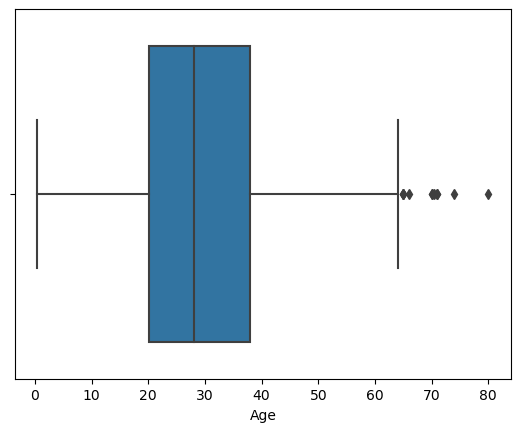

In [10]:
sns.boxplot(x=df1['Age'])
plt.show()

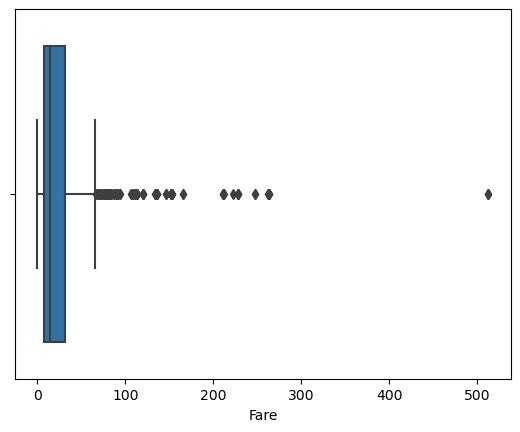

In [11]:
sns.boxplot(x=df1['Fare'])
plt.show()

In [12]:
q1 = df1['Age'].quantile(0.25)
q3 = df1['Age'].quantile(0.75)
iqr = q3 - q1
up = q3 + 1.5 * iqr
low = q1 - 1.5 * iqr
print(q1)
print(q3)
print(iqr)
print(up)
print(low)

20.125
38.0
17.875
64.8125
-6.6875


In [13]:
print(df1[(df1['Age'] < low) | (df1['Age'] > up) ])

     PassengerId  Survived  Pclass                                  Name  \
33            34         0       2                 Wheadon, Mr. Edward H   
54            55         0       1        Ostby, Mr. Engelhart Cornelius   
96            97         0       1             Goldschmidt, Mr. George B   
116          117         0       3                  Connors, Mr. Patrick   
280          281         0       3                      Duane, Mr. Frank   
456          457         0       1             Millet, Mr. Francis Davis   
493          494         0       1               Artagaveytia, Mr. Ramon   
630          631         1       1  Barkworth, Mr. Algernon Henry Wilson   
672          673         0       2           Mitchell, Mr. Henry Michael   
745          746         0       1          Crosby, Capt. Edward Gifford   
851          852         0       3                   Svensson, Mr. Johan   

      Sex   Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   male  66.0    

In [14]:
print(df1[(df1['Age'] < low) | (df1['Age']> up)].index)

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')


In [15]:
print(df1[(df1['Age'] < low) | (df1['Age'] > up)].any(axis=None)) #Checking Outliers B/W specified Threshold 

True


In [16]:
print(df1[df1['Age'] < low].any(axis=None))

False


In [76]:
def outlier_threshold(data, colname, q1= 0.25, q3 = 0.75):
    quantile1 = data[colname].quantile(q1)
    quantile3 = data[colname].quantile(q3)  
    interQuantileRange = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * interQuantileRange
    low_limit = quantile1 - 1.5 * interQuantileRange    
    return  low_limit,up_limit



In [77]:
print(outlier_threshold(df1, 'Age'))

(-6.6875, 64.8125)


In [78]:
low , up = outlier_threshold(df1, 'Fare')
print(low, up)
print(df1[(df1['Fare'] < low) | (df1['Fare'] > up)].head())

-26.724 65.6344
    PassengerId  Survived  Pclass  \
1             2         1       1   
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572   

In [52]:
def check_outlier(data, colname):
    low_limit, up_limit = outlier_threshold(data,colname)
    if data[(data[colname] > up_limit) | (data[colname] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [53]:
print(check_outlier(df1, 'Age'))
print(check_outlier(df1, 'Fare'))

True
True


In [54]:
def grab_col_names(data, cat_th = 10, car_th = 20):
    
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"] 
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    cat_but_car = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"] # cardinal columns
    cat_cols = cat_cols + num_but_cat 
    cat_cols = [col for col in cat_cols if col not in cat_but_car] #categorical column
    num_cols = [col for col in data.columns if data[col].dtypes !='O' and col not in num_but_cat] #numerical columns
    
    print(f'Observations : {data.shape[0]}')
    print(f"Variable : {data.shape[1]}")
    print(f"cat_cols : {len(cat_cols)}")
    print(f"num_cols : {len(num_cols)}")
    print(f"cat_but_car : {len(cat_but_car)}")
    print(f"num_but_cat : {len(num_but_cat)}")        
    
    return cat_cols, num_cols, cat_but_car


In [55]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

Observations : 891
Variable : 12
cat_cols : 6
num_cols : 3
cat_but_car : 3
num_but_cat : 4


In [56]:
num_cols = [col for col in num_cols if col not in 'PassengerId']
print(num_cols)

['Age', 'Fare']


In [57]:
#checking outliers in columns
for col in num_cols:
    print(col, check_outlier(df1, col))

Age True
Fare True


# Working but Large Dataset

In [58]:
def load_application_train():
    data = pd.read_csv('C:/Users/Sameer/Downloads/application_train.csv')
    return data

In [44]:
df = load_application_train()
df.shape

(307511, 122)

In [45]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations : 307511
Variable : 122
cat_cols : 54
num_cols : 67
cat_but_car : 1
num_but_cat : 39


In [60]:
#remove SK_ID_CURR as it's irrelevant
num_cols.remove('SK_ID_CURR')

In [79]:
#checking outliers in columns
for col in num_cols:
    print(col, check_outlier(df, col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True
REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI 

In [83]:
print(outlier_threshold(df,'DAYS_BIRTH'))

(-30585.5, -1509.5)


In [91]:
def grab_outliers(dataframe, col_name, outlier_index=False, f = 5):
    low, up = outlier_threshold(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head(f))
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if outlier_index:
        out_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return out_index

In [92]:
age_index = grab_outliers(df1,'Age', True)

     PassengerId  Survived  Pclass                            Name   Sex  \
33            34         0       2           Wheadon, Mr. Edward H  male   
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male   
96            97         0       1       Goldschmidt, Mr. George B  male   
116          117         0       3            Connors, Mr. Patrick  male   
280          281         0       3                Duane, Mr. Frank  male   

      Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
33   66.0      0      0  C.A. 24579  10.5000   NaN        S  
54   65.0      0      1      113509  61.9792   B30        C  
96   71.0      0      0    PC 17754  34.6542    A5        C  
116  70.5      0      0      370369   7.7500   NaN        Q  
280  65.0      0      0      336439   7.7500   NaN        Q  


In [86]:
print(age_index)

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')


# Handling Outliers

In [90]:
low , up = outlier_threshold(df1, 'Fare')
print(df1.shape)

(891, 12)


In [94]:
fare_index = grab_outliers(df1,'Fare', True)


    PassengerId  Survived  Pclass  \
1             2         1       1   
27           28         0       1   
31           32         1       1   
34           35         0       1   
52           53         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
27                     Fortune, Mr. Charles Alexander    male  19.0      3   
31     Spencer, Mrs. William Augustus (Marie Eugenie)  female   NaN      1   
34                            Meyer, Mr. Edgar Joseph    male  28.0      1   
52           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female  49.0      1   

    Parch    Ticket      Fare        Cabin Embarked  
1       0  PC 17599   71.2833          C85        C  
27      2     19950  263.0000  C23 C25 C27        S  
31      0  PC 17569  146.5208          B78        C  
34      0  PC 17604   82.1708          NaN        C  
52      0  PC 17572   76.7292         

In [95]:
print(len(fare_index))

116


In [97]:
print(df1[~((df1['Fare'] < low) | (df1['Fare'] > up))].shape) #Data shape without outlier for fare column

(775, 12)


# Removing Outliers

In [104]:
def remove_outliers(data, colname):
    low_limit, up_limit = outlier_threshold(data,colname)
    data_without_outliers = data[~((data[colname] < low_limit) | (data[colname] > up_limit))]
    return data_without_outliers


In [100]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

Observations : 891
Variable : 12
cat_cols : 6
num_cols : 3
cat_but_car : 3
num_but_cat : 4


In [101]:
print([col for col in num_cols])

['PassengerId', 'Age', 'Fare']


In [102]:
num_cols.remove('PassengerId')

In [105]:
for col in num_cols:
    df1 = remove_outliers(df1,col)

In [106]:
print(df1.shape) #After removing all outliers for Age and Fare

(765, 12)


## Replacing Outliers With Threshold

In [107]:
def replace_with_threshold(data, variable):
    low_limit, up_limit = outlier_threshold(data,variable)
    data.loc[(data[variable] < low_limit), variable] = low_limit
    data.loc[(data[variable] > up_limit), variable] = up_limit

In [108]:
df1 = load_titanic()

In [109]:
cat_cols, num_cols, cat_but_car = grab_col_names(df1)

Observations : 891
Variable : 12
cat_cols : 6
num_cols : 3
cat_but_car : 3
num_but_cat : 4


In [110]:
num_cols.remove('PassengerId')

In [111]:
for col in num_cols:
    print(col, check_outlier(df1,col))

Age True
Fare True


In [112]:
for col in num_cols:
    replace_with_threshold(df1, col)

In [113]:
for col in num_cols:
    print(col, check_outlier(df1,col))

Age False
Fare False


# Using Diamond Dataset From Seaborn

In [114]:
df = sns.load_dataset('diamonds')
print(df.shape)
print(df.head())


(53940, 10)
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75


In [115]:
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()
print(df.shape)
print(df.head())

(53940, 7)
   carat  depth  table  price     x     y     z
0   0.23   61.5   55.0    326  3.95  3.98  2.43
1   0.21   59.8   61.0    326  3.89  3.84  2.31
2   0.23   56.9   65.0    327  4.05  4.07  2.31
3   0.29   62.4   58.0    334  4.20  4.23  2.63
4   0.31   63.3   58.0    335  4.34  4.35  2.75


In [116]:
for col in df.columns:
    print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [117]:
#checking rows that contain outlier
low, up = outlier_threshold(df, 'carat')
print(df[((df['carat'] < low) | (df['carat'] > up))].shape)


(1889, 7)


In [118]:
low, up = outlier_threshold(df, 'depth')
print(df[((df['depth'] < low) | (df['depth'] > up))].shape)

(2545, 7)


In [119]:
low, up = outlier_threshold(df, 'price')
print(df[((df['price'] < low) | (df['price'] > up))].shape)

(3540, 7)


In [121]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
print(df_scores)
print(len(df_scores))

[-1.58352526 -1.59732899 -1.62278873 ... -1.06721815 -1.00809552
 -1.00849038]
53940


In [122]:
print(np.sort(df_scores)[0:5]) #If the value is closer to 1 then there is less chance for it being outlier

[-8.60430658 -8.20889984 -5.86084355 -4.98415175 -4.81502092]


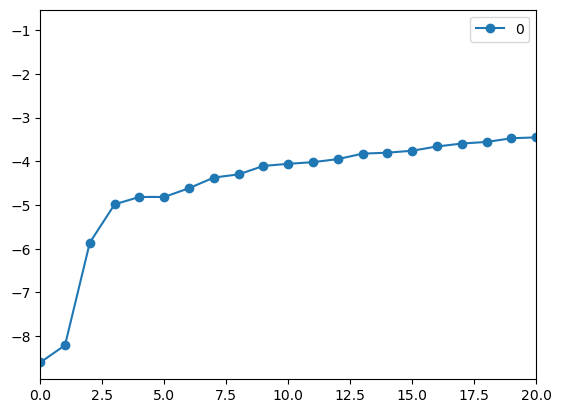

In [135]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim = [0,20], style="o-")
plt.show() #focus the plot on the range from 0 to 20 only

In [136]:
th = np.sort(scores)[3]
print(th)

[-4.98415175]


In [139]:
print(df[df_scores < th])

       carat  depth  table  price     x      y      z
41918   1.03   78.2   54.0   1262  5.72   5.59   4.42
48410   0.51   61.8   54.7   1970  5.12   5.15  31.80
49189   0.51   61.8   55.0   2075  5.15  31.80   5.12


In [140]:
#Dropping the outliers
print(df.drop(axis=0, labels=df[df_scores < th].index).shape)

(53937, 7)
